## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (170062, 8)


In [5]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

All caught up..!
size of dataset: (167199, 8)


In [6]:
#dir(crypto.binance_client)
crypto.binance_client.get_account()

{'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00224170', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000664', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '107.65342381', 'locked': '0.00000000'},
  {'asset': 'HSR', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'OAX', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'DNT', 'free': '0.000000

### Generate Candles and build features from technical analysis

In [7]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [8]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

In [9]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

343

,Close,Pred Close
Date,,
2022-05-08 21:01:00,34282.00,34531.807579
2022-05-08 21:16:00,34315.21,34548.563262
2022-05-08 21:31:00,34430.30,34555.433780
2022-05-08 21:46:00,34460.70,34572.893209
2022-05-08 22:01:00,34176.87,34611.592652
...,...,...
2022-06-29 09:31:00,20110.01,20214.051329
2022-06-29 09:46:00,20063.27,20219.897324
2022-06-29 10:01:00,20107.68,20187.747622


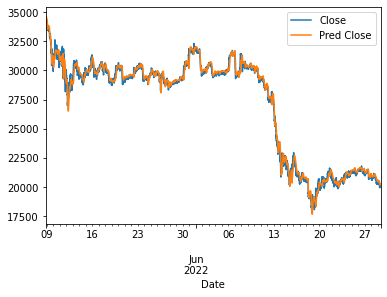

In [10]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

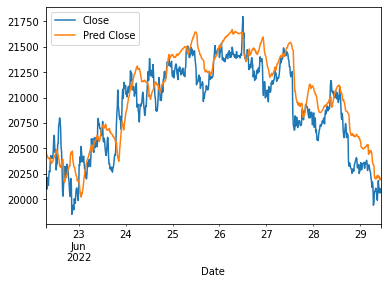

In [11]:
df_preds_true.dropna().iloc[-new_time_steps*2:].plot()

In [12]:
def kelly_exp_simple(pct_gain,pct_loss,n_wins):

  if pct_loss != 0.0 and pct_gain != 0.0:
      win_loss_ratio = pct_gain/pct_loss
      kelly_frac = n_wins - (1- n_wins)/win_loss_ratio
  else:
      kelly_frac = np.nan
  return kelly_frac

def backtest_temp_df(df_preds_true, step_back = 10, long_short = "long", fee=0.025, cutoff_long = 10.,cutoff_short = 10.0):

    if long_short != "long" and long_short != "short" and long_short != "longshort":
        raise ValueError("long_short can only be long, short or longshort")

    if cutoff_long < 1.0 or cutoff_short < 1.0:
        raise ValueError("cutoff_long and cutoff_short should be greater/equal to 1.0")      

    wallet = 0
    total_wallet_history = []
    single_wallet_history = []
    datetime_iter = []

    fee_factor_long = (1+fee/cutoff_long)
    fee_factor_short = (1+fee/cutoff_short)

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0
    mean_pct_gain = 0
    mean_pct_loss = 0

    delta = df_preds_true.index[1]-df_preds_true.index[0]
    df_preds_true.iloc[:,0] = df_preds_true.iloc[:,0].shift(step_back,delta)

    previous_true_close = df_preds_true.iloc[step_back,0]
    previous_pred_close = df_preds_true.iloc[step_back,-1]
    print("Initial time", df_preds_true.index[0])
    print("Final time", df_preds_true.index[-1])
    it = 0

    for index, row in df_preds_true.iloc[step_back+1:].iterrows():
        true_close = row[0]
        pred_close = row[-1]
        it+=1

        if long_short == "long":
            if previous_true_close* fee_factor_long < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += (true_close/previous_true_close)                   

                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += (true_close/previous_true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                datetime_iter.append(it)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        elif long_short == "short":
            if  previous_true_close * fee_factor_short > pred_close:  # short
                profit = -1*(true_close - previous_true_close)
                if profit > 0:
                    # win
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += (previous_true_close/true_close)             
                else:
                    #loss
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    #if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += (previous_true_close/true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                datetime_iter.append(it)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        elif long_short == "longshort":
            if  previous_true_close *fee_factor_short > pred_close:  # short
                profit = true_close - previous_true_close
                if profit < 0:
                    # win
                    profit = -1*(profit - (profit * fee))
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += (previous_true_close/true_close)                  
                else:
                    #loss
                    profit = -1*(profit + (profit * fee))
                    buys_cnt_losses += 1
                    #if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += (previous_true_close/true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                datetime_iter.append(it)
                buys_cnt += 1
            elif previous_true_close * fee_factor_long < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += (true_close/previous_true_close)
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += (true_close/previous_true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                datetime_iter.append(it)
                buys_cnt += 1

        previous_true_close = true_close
        previous_pred_close = pred_close

    if buys_cnt_win != 0.0:
        mean_pct_gain /= buys_cnt_win
        wins_pct =  buys_cnt_win/buys_cnt
    else:
        wins_pct = 0.0
    if buys_cnt_losses !=  0.0:
        mean_pct_loss /= buys_cnt_losses
    
    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('Avg PCT gain:', mean_pct_gain)
    print('Avg PCT loss:', mean_pct_loss)
    print('Wins  PCT  ', wins_pct)
    print('Avg PCT Gain.   ', mean_pct_gain)
    print('No-op   ', buys_cnt - buys_cnt_win - buys_cnt_losses)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    kelly_frac = kelly_exp_simple(mean_pct_gain,mean_pct_loss,wins_pct)

    print('Kelly Fraction   ',kelly_frac)

    wallet_hist_df = pd.DataFrame(np.array([total_wallet_history, single_wallet_history]).T,
                                            index=df_preds_true.index[datetime_iter],
                                            columns=["Tot. Wallet hist", "Single Wallet hist" ])

    return wallet_hist_df, wallet, kelly_frac


In [13]:
wallet_hist_df,wallet,kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-new_time_steps:], ts_btc.step_back-ts_btc.step_back + 10 , 
                                                    long_short = "short", fee=0.025, cutoff_long = 10. ,cutoff_short = 10.0)
s2b.show_backtest_results(wallet,wallet_hist_df)

AttributeError: ignored

In [67]:
investment = 100.
conservative_kelly = kelly_frac*.5
portfolio = investment
order_status = "not_filled"

while True:

  ldata_df_new = crypto.load_cryptos(tickers,save = False)
  can_btc = fb.Candles(ldata_df_new,"Bitcoin")
  can_btc.buildfeatures()
  ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = "15m",
                  lownorm = 0.2, upnorm= 0.8)

  ts_btc.candles2ts()
  ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
  ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
  initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
  loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
  loaded_model.sats2model()
  loaded_model.load_model(model_name)
  loaded_model.sats2pred(predict_on_test = False)
  loaded_model.load_scaler(model_name + '/scaler.sav')
  preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
  new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
  df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
  df_preds_true.dropna().iloc[-new_time_steps:].plot()
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)

  prev_true_close = df_preds_true_shifted.iloc[-2,0]
  prev_pred_close = df_preds_true_shifted.iloc[-2,1]
  pred_close = df_preds_true_shifted.iloc[-1,1]

  fee = 0.025

  elapsed_minutes = (pd.Timestamp(datetime.now()) - df_preds_true.index[-1]).seconds/crypto.dt
  time_condition = delta.seconds/crypto.dt -1. < elapsed_minutes <  delta.seconds/crypto.dt + 1.

  if time_condition and order_status == "not_filled" :

    if prev_true_close*(1+fee) < pred_close:

        #get price
        price = crypto.binance_client.get_symbol_ticker(symbol=tickers[0])
        # Calculate how much to buy
        buy_quantity = round(portfolio*conservative_kelly / float(price['price']))
        buy_quantity = 0.001
        order = crypto.binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)
        
        order_status= "filled"
        






All caught up..!
size of dataset: (170060, 8)
Candles Normalized
Extracted last 2000 steps


KeyboardInterrupt: ignored

In [ ]:
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)
  df_preds_true_shifted

In [ ]:
df_preds_true